In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import json
import pandas as pd
import numpy as np
import operator
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

stemmer = SnowballStemmer("english")

pd.options.display.max_colwidth = 200

In [3]:
df = pd.read_csv(".\DATASETS\EJOR_DATABASE_ABSTRACT_KEYWORDS.csv") #all 19k papers, changed desired path
df = df[df['Year'] <= 2022]
df['Category'] = df['Text'].apply(lambda x: "Maintenance" if stemmer.stem("maintenance") in x else "Non-Maintenance")
df['YearDiff'] = 2023 - df['Year']
df['CitedByYear'] = df['Cited by'] / df['YearDiff']

contain_values_M = df[(df['Text'].str.contains(stemmer.stem('maintenance')))]
contain_values_M = contain_values_M.reset_index(drop=True)

# Table of contents

## 1. General Analysis
### 1.1 Trend Analysis
### 1.2 Fraction of papers about Maintenance
### 1.3 Citations
### 1.4 Authors
## 2. Interfaces

## 1. General Analysis

### 1.1 Trend analysis ###

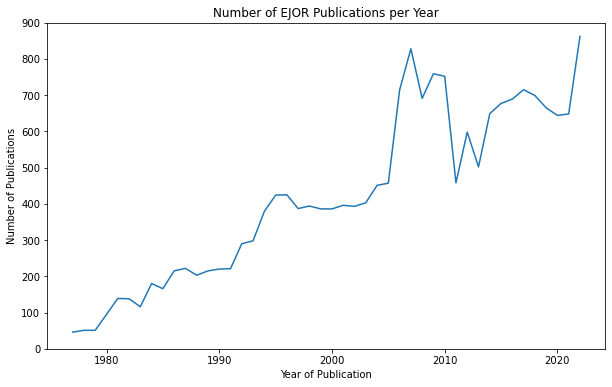

In [3]:
#All papers

years_count = df.groupby("Year")['Year'].count().reset_index(name="Count")

plt.figure(figsize = (10,6))

sns.lineplot(x = 'Year', y = "Count", data = years_count)

plt.xlabel("Year of Publication")

plt.ylabel("Number of Publications")

plt.title("Number of EJOR Publications per Year")
plt.ylim(0,900)

plt.show()

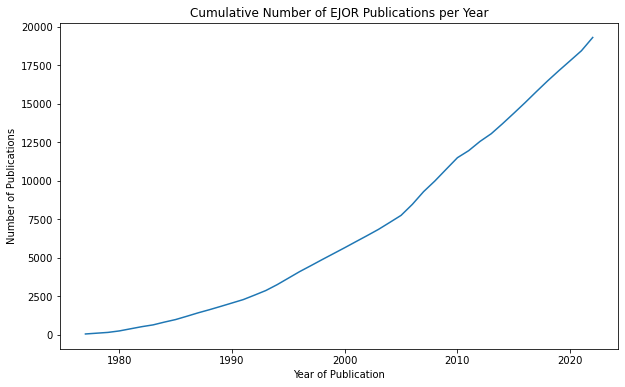

In [4]:
#All papers cumul

years_count_cumsum = df.groupby("Year")['Year'].count().cumsum().reset_index(name="Count")

plt.figure(figsize = (10,6))

sns.lineplot(x = 'Year', y = "Count", data = years_count_cumsum)

plt.xlabel("Year of Publication")

plt.ylabel("Number of Publications")

plt.title("Cumulative Number of EJOR Publications per Year")
#plt.ylim(0,900)

plt.show()

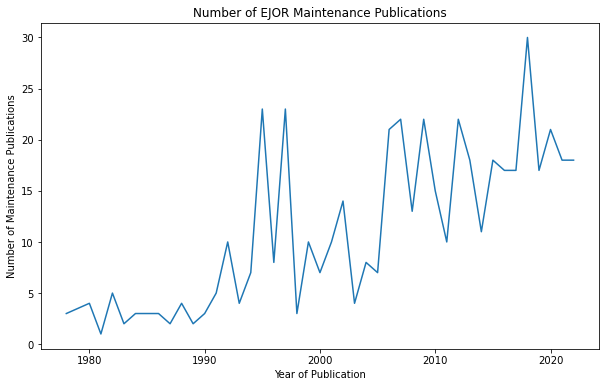

In [5]:
#Maintenance papers

years_count_M = contain_values_M.groupby("Year")['Year'].count().reset_index(name="Count")

plt.figure(figsize = (10,6))

sns.lineplot(x = 'Year', y = "Count", data = years_count_M)

plt.xlabel("Year of Publication")

plt.ylabel("Number of Maintenance Publications")

plt.title("Number of EJOR Maintenance Publications")

#plt.ylim(0,900)
plt.show()

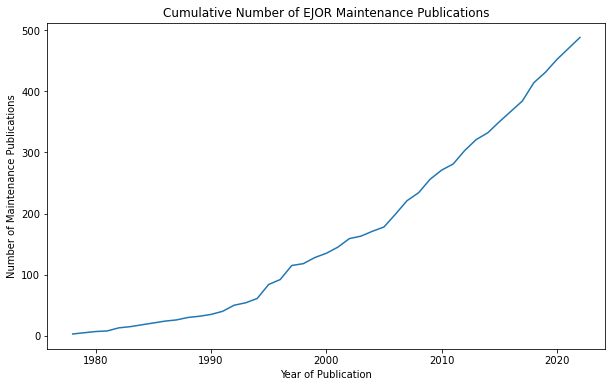

In [6]:
#Maintenance Papers Cumul

years_count_M = contain_values_M.groupby("Year")['Year'].count().cumsum().reset_index(name="Count")

plt.figure(figsize = (10,6))

sns.lineplot(x = 'Year', y = "Count", data = years_count_M)

plt.xlabel("Year of Publication")

plt.ylabel("Number of Maintenance Publications")

plt.title("Cumulative Number of EJOR Maintenance Publications")

plt.show()

### 1.2 Fraction of papers about Maintenance ###

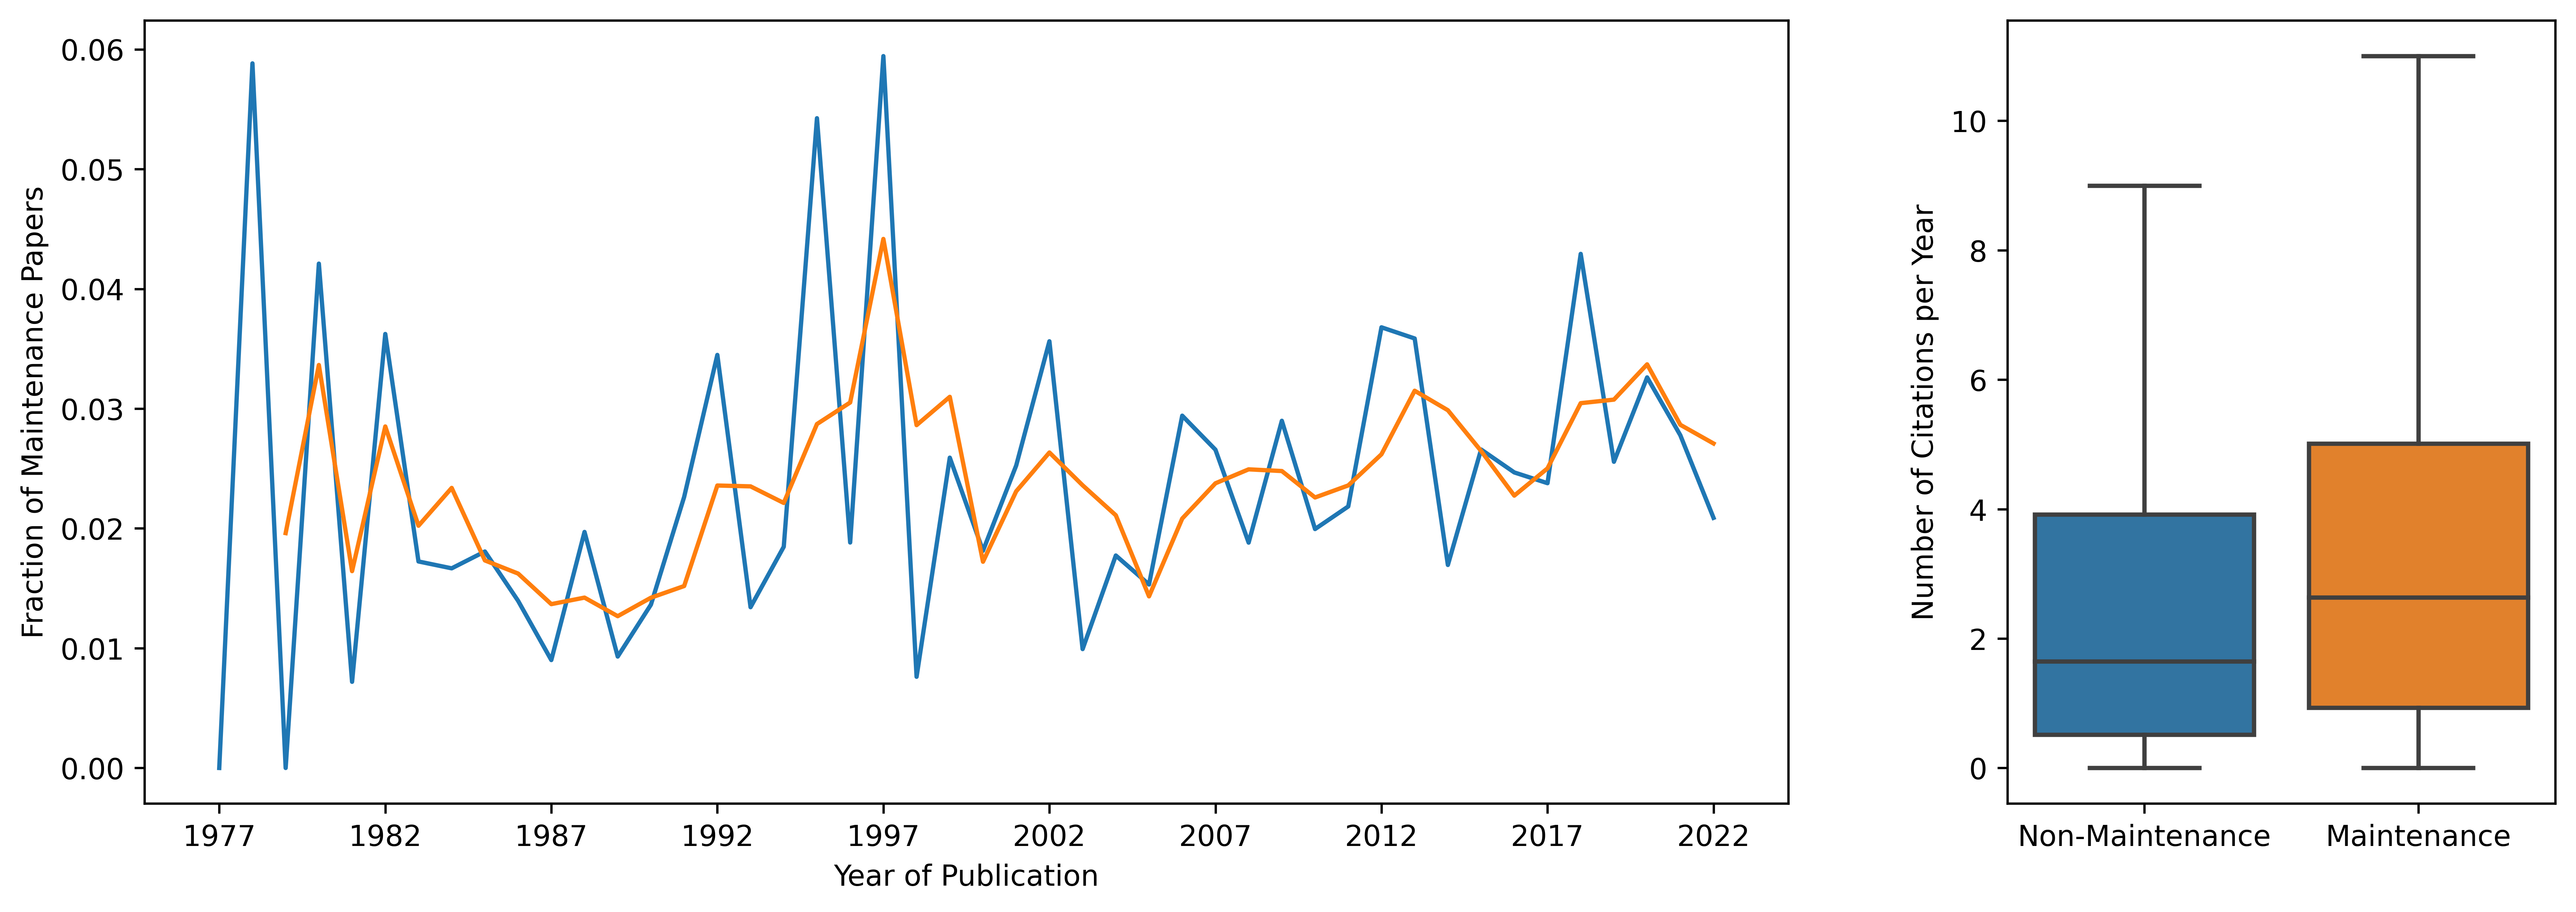

In [53]:
#fraction of maintenance papers

k = 3
f, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5), dpi = 600, gridspec_kw={'width_ratios': [3, 1]})
plt.rcParams.update({'font.size': 10})

#data
maintenance_fraction = contain_values_M.groupby("Year")['Year'].count() / df.groupby("Year")['Year'].count()
maintenance_fraction = maintenance_fraction.fillna(0)
maintenance_fraction = maintenance_fraction.reset_index(name="MaintenanceFraction")
maintenance_fraction['Smoothed_Avg'] = maintenance_fraction['MaintenanceFraction'].rolling(window=k).mean()
#enddata

#plt.figure(figsize=(7, 5), dpi = 300)

#fraction
sns.lineplot(x="Year",y="MaintenanceFraction", data= maintenance_fraction, ax = ax1)
sns.lineplot(x="Year", y="Smoothed_Avg", data=maintenance_fraction, ax = ax1)

ax1.set_xlabel("Year of Publication")
ax1.set_xticks(range(1977,2023,5))

ax1.set_ylabel("Fraction of Maintenance Papers")


#citations

sns.boxplot(x="Category", y = "CitedByYear", data = df, showfliers = False, orient='v', ax = ax2)
ax2.set_ylabel("Number of Citations per Year")
ax2.set_xlabel("")


#plt.title("Fraction of EJOR Papers on Maintenance")

plt.savefig(".\Graphs\maintfractandcitations.jpg", format='jpeg', bbox_inches='tight')
plt.show()

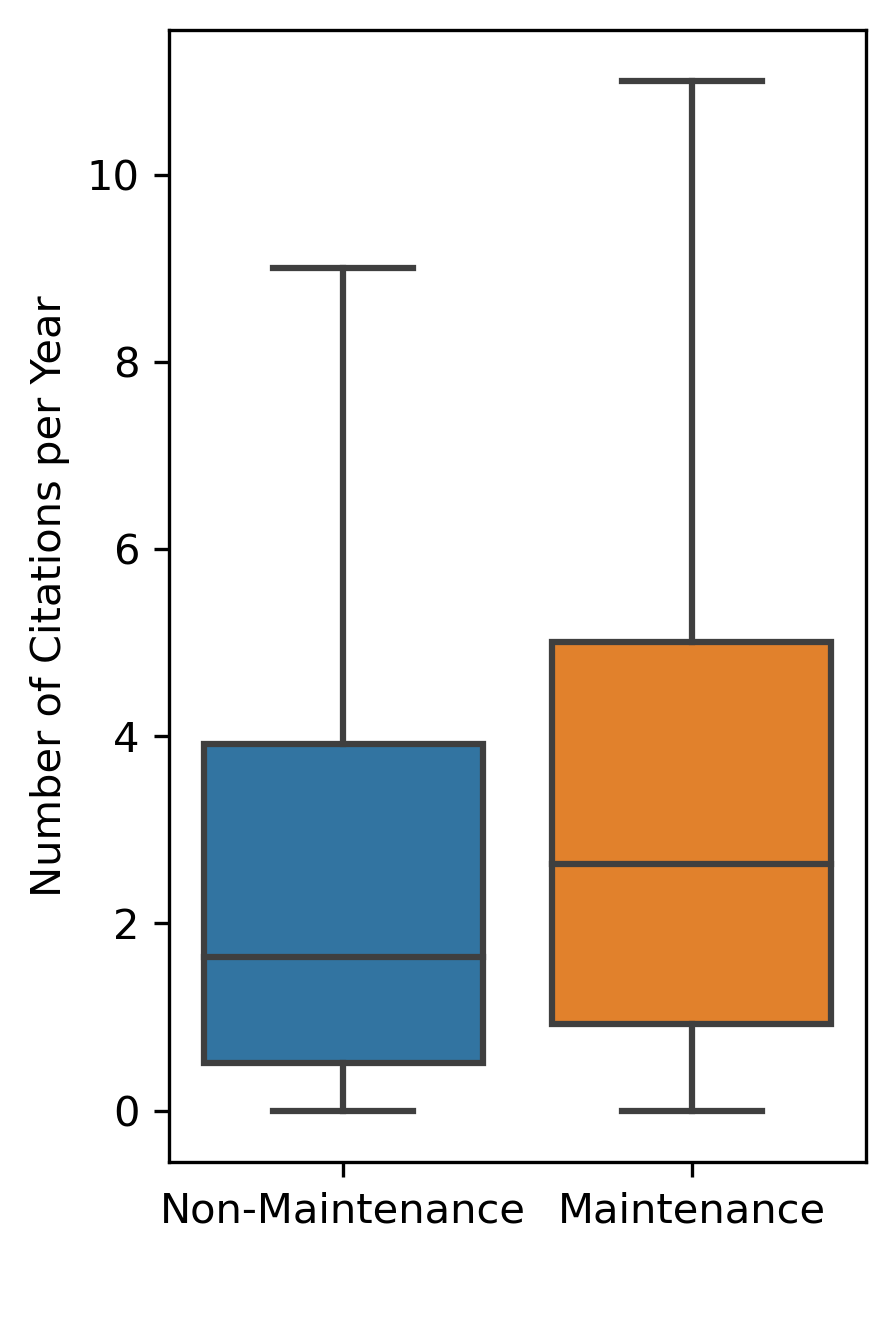

In [9]:
plt.figure(figsize=(3, 5), dpi = 300)

sns.boxplot(x="Category", y = "CitedByYear", data = df, showfliers = False, orient='v')

plt.rcParams.update({'font.size': 10})
plt.ylabel("Number of Citations per Year")
plt.xlabel(" ")


plt.savefig(".\Graphs\MaintenanceCitedBox.jpg", format='jpeg', bbox_inches='tight')
plt.show()

### 1.3 Citations ####

In [12]:
qlist = []
qall = []
qm = []

for i in np.arange(0.1,1.1,0.1):
    qlist.append(str(round(i * 100)) + "th")
    qall.append(df['Cited by'].quantile(i))
    qm.append(contain_values_M['Cited by'].quantile(i))
quantdf = pd.DataFrame({"Quantile": qlist, "All Papers": qall, "Maintenance Papers": qm})
quantdf['ratio'] = quantdf['Maintenance Papers'] / quantdf['All Papers']
quantdf

,Quantile,All Papers,Maintenance Papers,ratio
0,10th,2.0,4.0,2.000000
1,20th,5.0,8.0,1.600000
2,30th,9.0,14.0,1.555556
3,40th,13.0,19.0,1.461538
4,50th,19.0,25.0,1.315789
5,60th,27.0,37.0,1.370370
6,70th,38.0,51.0,1.342105
7,80th,57.0,70.0,1.228070
8,90th,97.0,104.6,1.078351
9,100th,18616.0,1449.0,0.077836


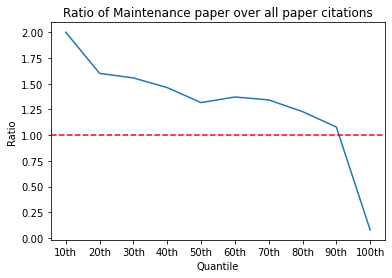

In [13]:
sns.lineplot(x="Quantile", y="ratio", data = quantdf)

ax = plt.gca()
ax.axhline(y=1, color='red', linestyle='--', label='y = 1')

plt.xlabel("Quantile")
plt.ylabel("Ratio")
plt.title("Ratio of Maintenance paper over all paper citations")

plt.show()

In [15]:
#test for significance 

from scipy import stats

OtherPapers = df[df['Category'] == "Non-Maintenance"]['CitedByYear'].to_numpy()
MaintenancePapers = df[df['Category'] == "Maintenance"]['CitedByYear'].to_numpy()

t_statistic, p_value = stats.ttest_ind(OtherPapers, MaintenancePapers)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -2.761841841767742
P-value: 0.005753067320039258


In [19]:
OtherPapers.mean()

3.440171235956625

In [21]:
df[df['Category'] == "Maintenance"].sort_values("Cited by",ascending=False).head(20).to_csv("top20Maintenance.csv",index=False)

### 1.4 Authors ###

In [4]:
#Most cited authors in maintenance
from pybliometrics.scopus import AuthorRetrieval

df['Author(s) ID'] = df['Author(s) ID'].replace('[No author name available]', '0')
df['AuthorsIDClean'] = df['Author(s) ID'].str.split(";").map(lambda x: [int(i) for i in x])
authordf = df.explode("AuthorsIDClean")
grouped_count = authordf.groupby("AuthorsIDClean", as_index=False)['Cited by'].sum()
grouped_count = grouped_count.sort_values(by="Cited by", ascending = False).reset_index()

top500 = grouped_count.head(500)

top500['name_author'] = top500['AuthorsIDClean'].apply(lambda x: AuthorRetrieval(x).indexed_name)

C:\Users\u0156959\AppData\Local\Temp\ipykernel_15720\1912107919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top500['name_author'] = top500['AuthorsIDClean'].apply(lambda x: AuthorRetrieval(x).indexed_name)


## 2. Interfaces ##

## 2.1 Spare parts and inventory 

In [35]:
keyword1 = "spare parts"
keyword2 = "inventory"
keyword3 = "forecasting"
keyword4 = "stocking"

check1 = contain_values_M['Text'].str.contains(stemmer.stem(keyword1))
check2 = contain_values_M['Text'].str.contains(stemmer.stem(keyword2))
check3 = contain_values_M['Text'].str.contains(stemmer.stem(keyword3))
check4 = contain_values_M['Text'].str.contains(stemmer.stem(keyword4))


sif = contain_values_M[check1 | check2 | check4]
sif.to_excel("Final.xlsx")
sif.count()

Authors          52
Author(s) ID     52
Title            52
Year             52
Source title     52
Volume           52
Issue            52
Page start       52
Page end         52
Cited by         52
DOI              52
Link             52
Document Type    52
Open Access       7
Abstract         52
Keywords         52
Text             52
Category         52
YearDiff         52
CitedByYear      52
dtype: int64

## 2.2 Production and maintenance

In [16]:
RevenueInMaintenance = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("revenue")))]
RevenueInMaintenance

In [14]:
ProductRateInMaintenance = contain_values_M[(contain_values_M['Text'].str.contains("product rate"))]
ProductRateInMaintenance

## 2.3 Design for maintenance

In [4]:
DesignInMaintenance = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("design")))]
DesignInMaintenance

In [7]:
RedundancyReliability = df[(df['Text'].str.contains(stemmer.stem("redundancy"))) & (df['Text'].str.contains(stemmer.stem("reliability")))]
RedundancyReliability

## 2.4 resource constraints

In [9]:
CapacityMaintenance = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("capacity")))]
CapacityMaintenance

In [11]:
MachineRepair = df[(df['Text'].str.contains(stemmer.stem("machin repair ")))]
MachineRepair

## 2.5 transportation

In [15]:
TransportationInMaintenance = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("transportation")))]
TransportationInMaintenance

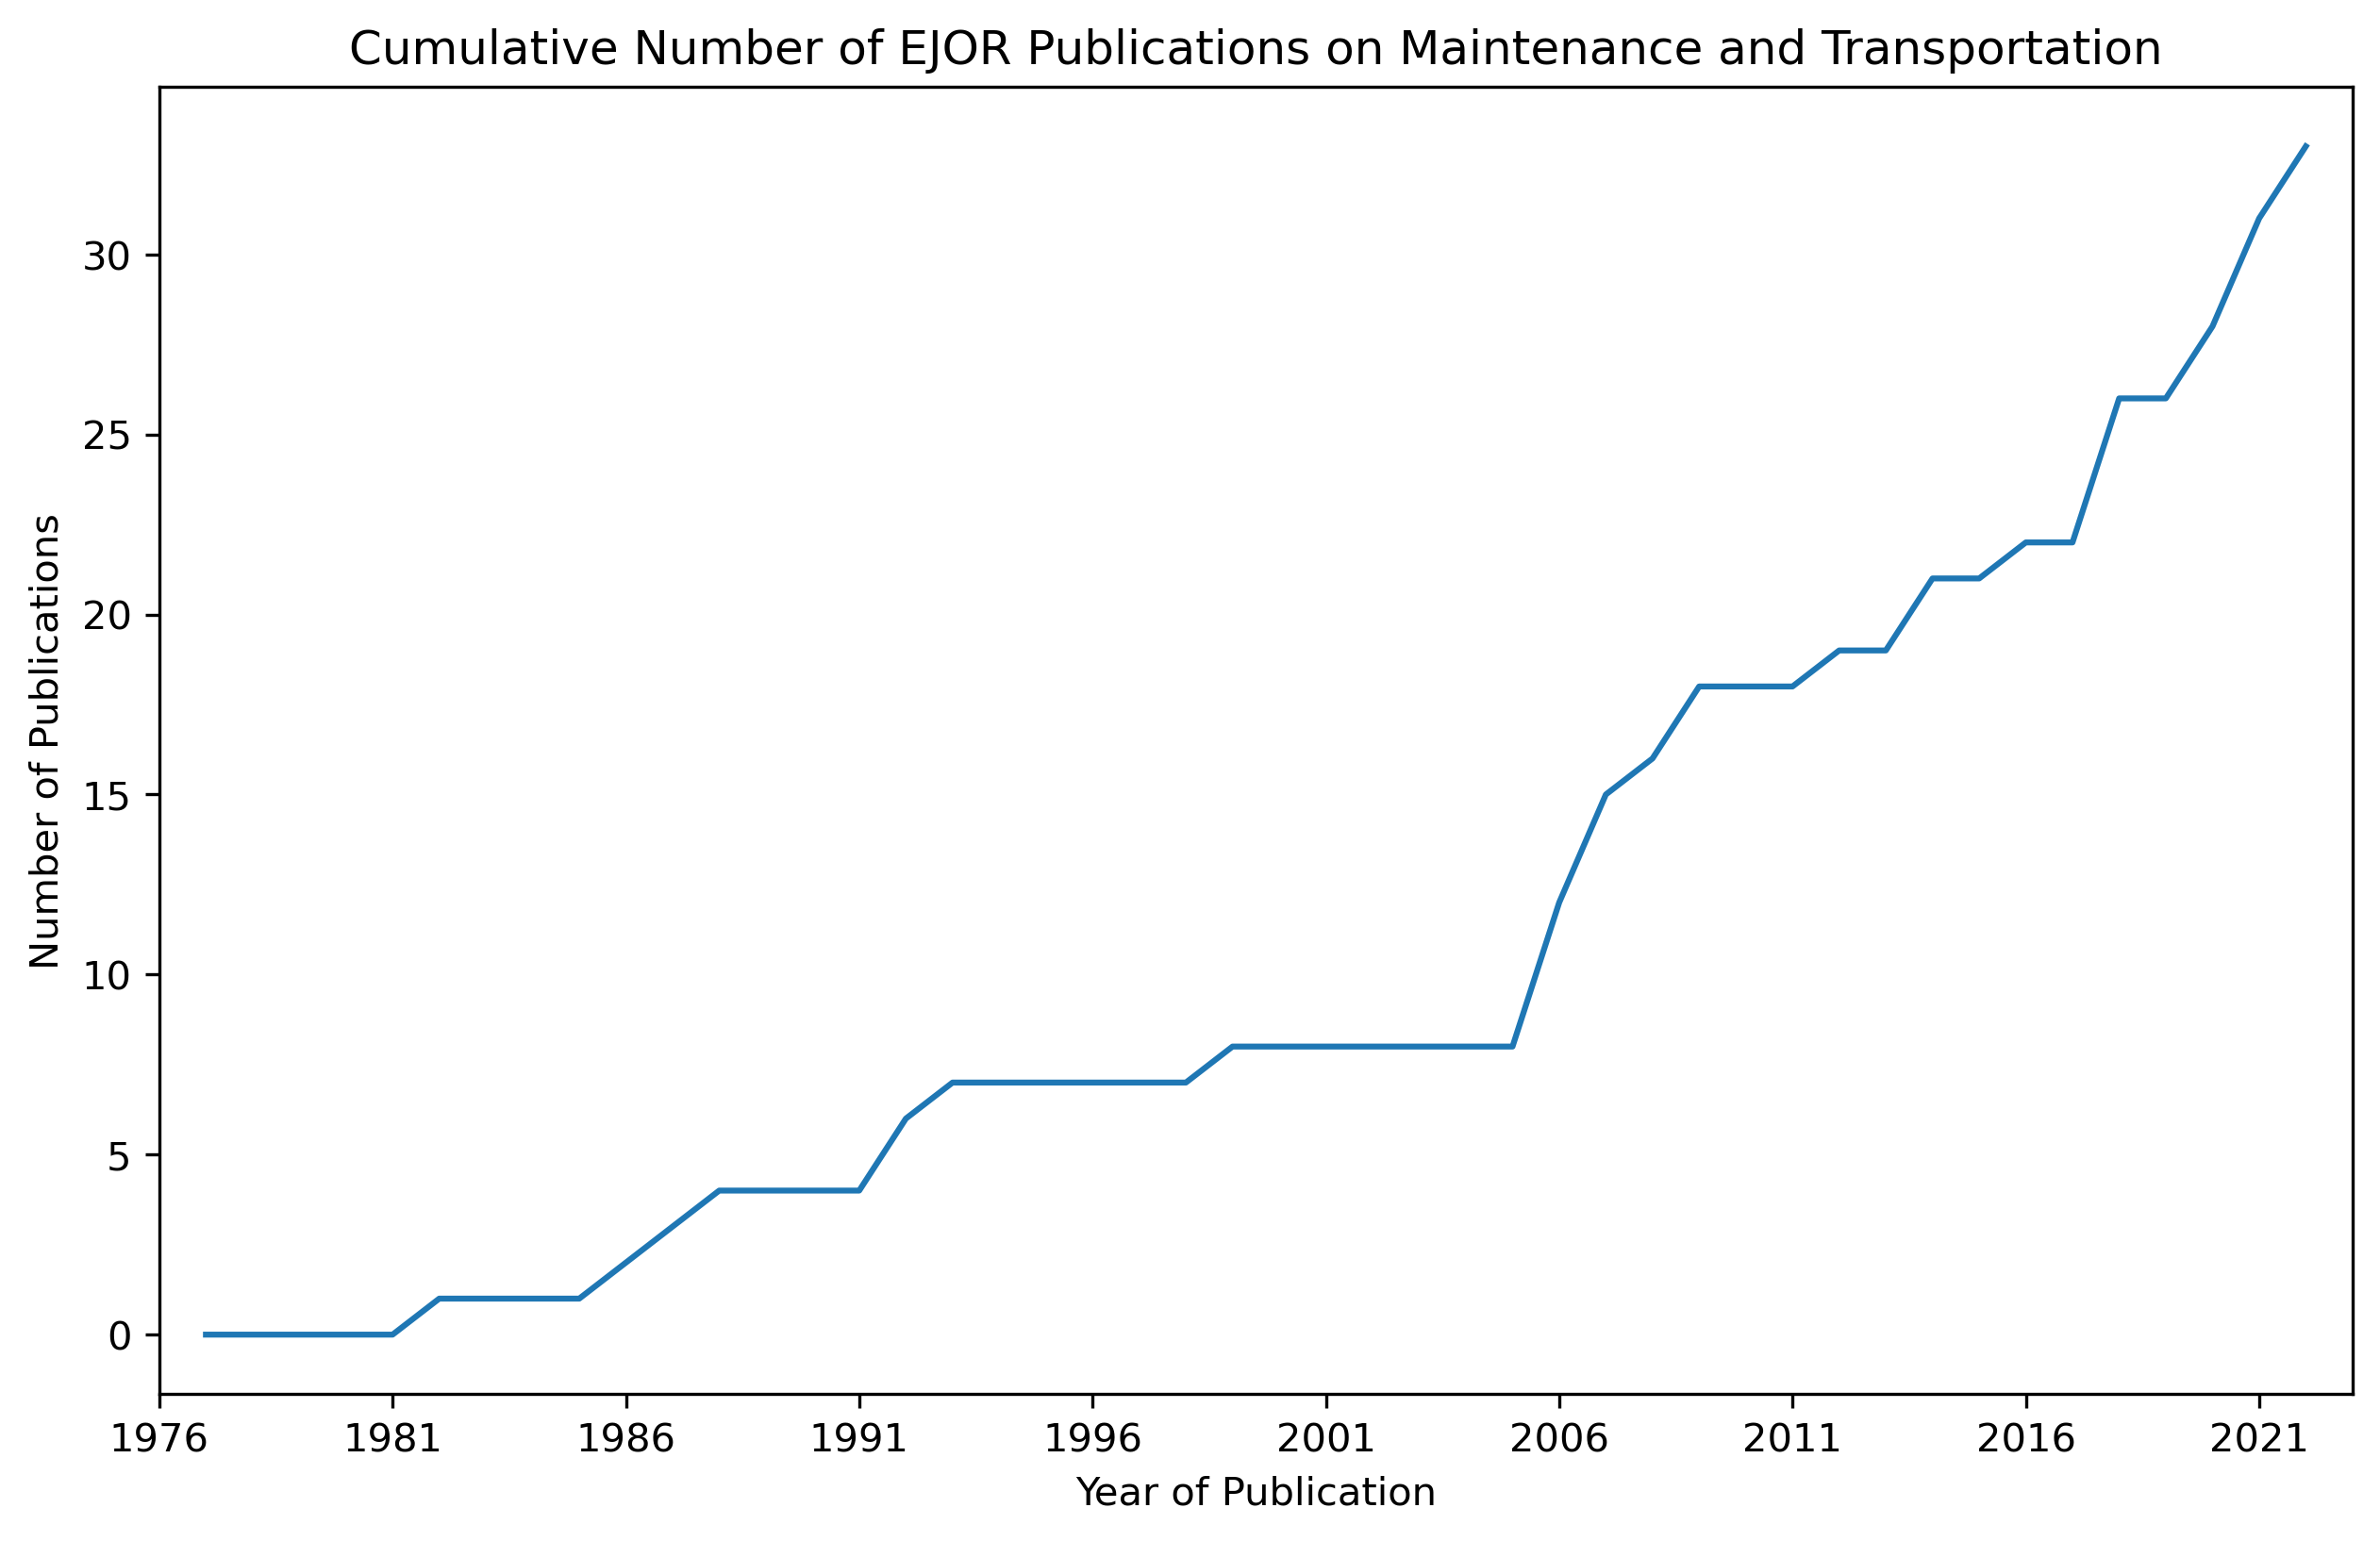

In [87]:
#graph on transportation in papers about maintenance
lookat = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("transportation")))]
lookatgroup = lookat.groupby("Year")["Year"].count().to_dict()

for i in range(1977,2023):
    if i not in lookatgroup:
        lookatgroup[i] = 0
        
mykeys = list(lookatgroup.keys())
mykeys.sort()
sorted_lookatgroup = {i: lookatgroup[i] for i in mykeys}

yearsar = list(sorted_lookatgroup.keys())
valuesar = list(sorted_lookatgroup.values())

updateddf = pd.DataFrame(data = {"Year": yearsar, "Number of Publications": valuesar})
updateddf["Cumulative Number"] = updateddf["Number of Publications"].cumsum() 

plt.figure(figsize=(10, 6), dpi = 300)

sns.lineplot(x="Year",y="Cumulative Number",data= updateddf)

plt.xlabel("Year of Publication")
plt.ylabel("Number of Publications")
plt.title("Cumulative Number of EJOR Publications on Maintenance and Transportation")
plt.xlim(1976,2023)
plt.xticks(range(1976,2023,5))

plt.savefig(".\Graphs\CumulTransportation.jpg", format='jpeg', bbox_inches='tight')
plt.show()

## 2.6 Service contracts

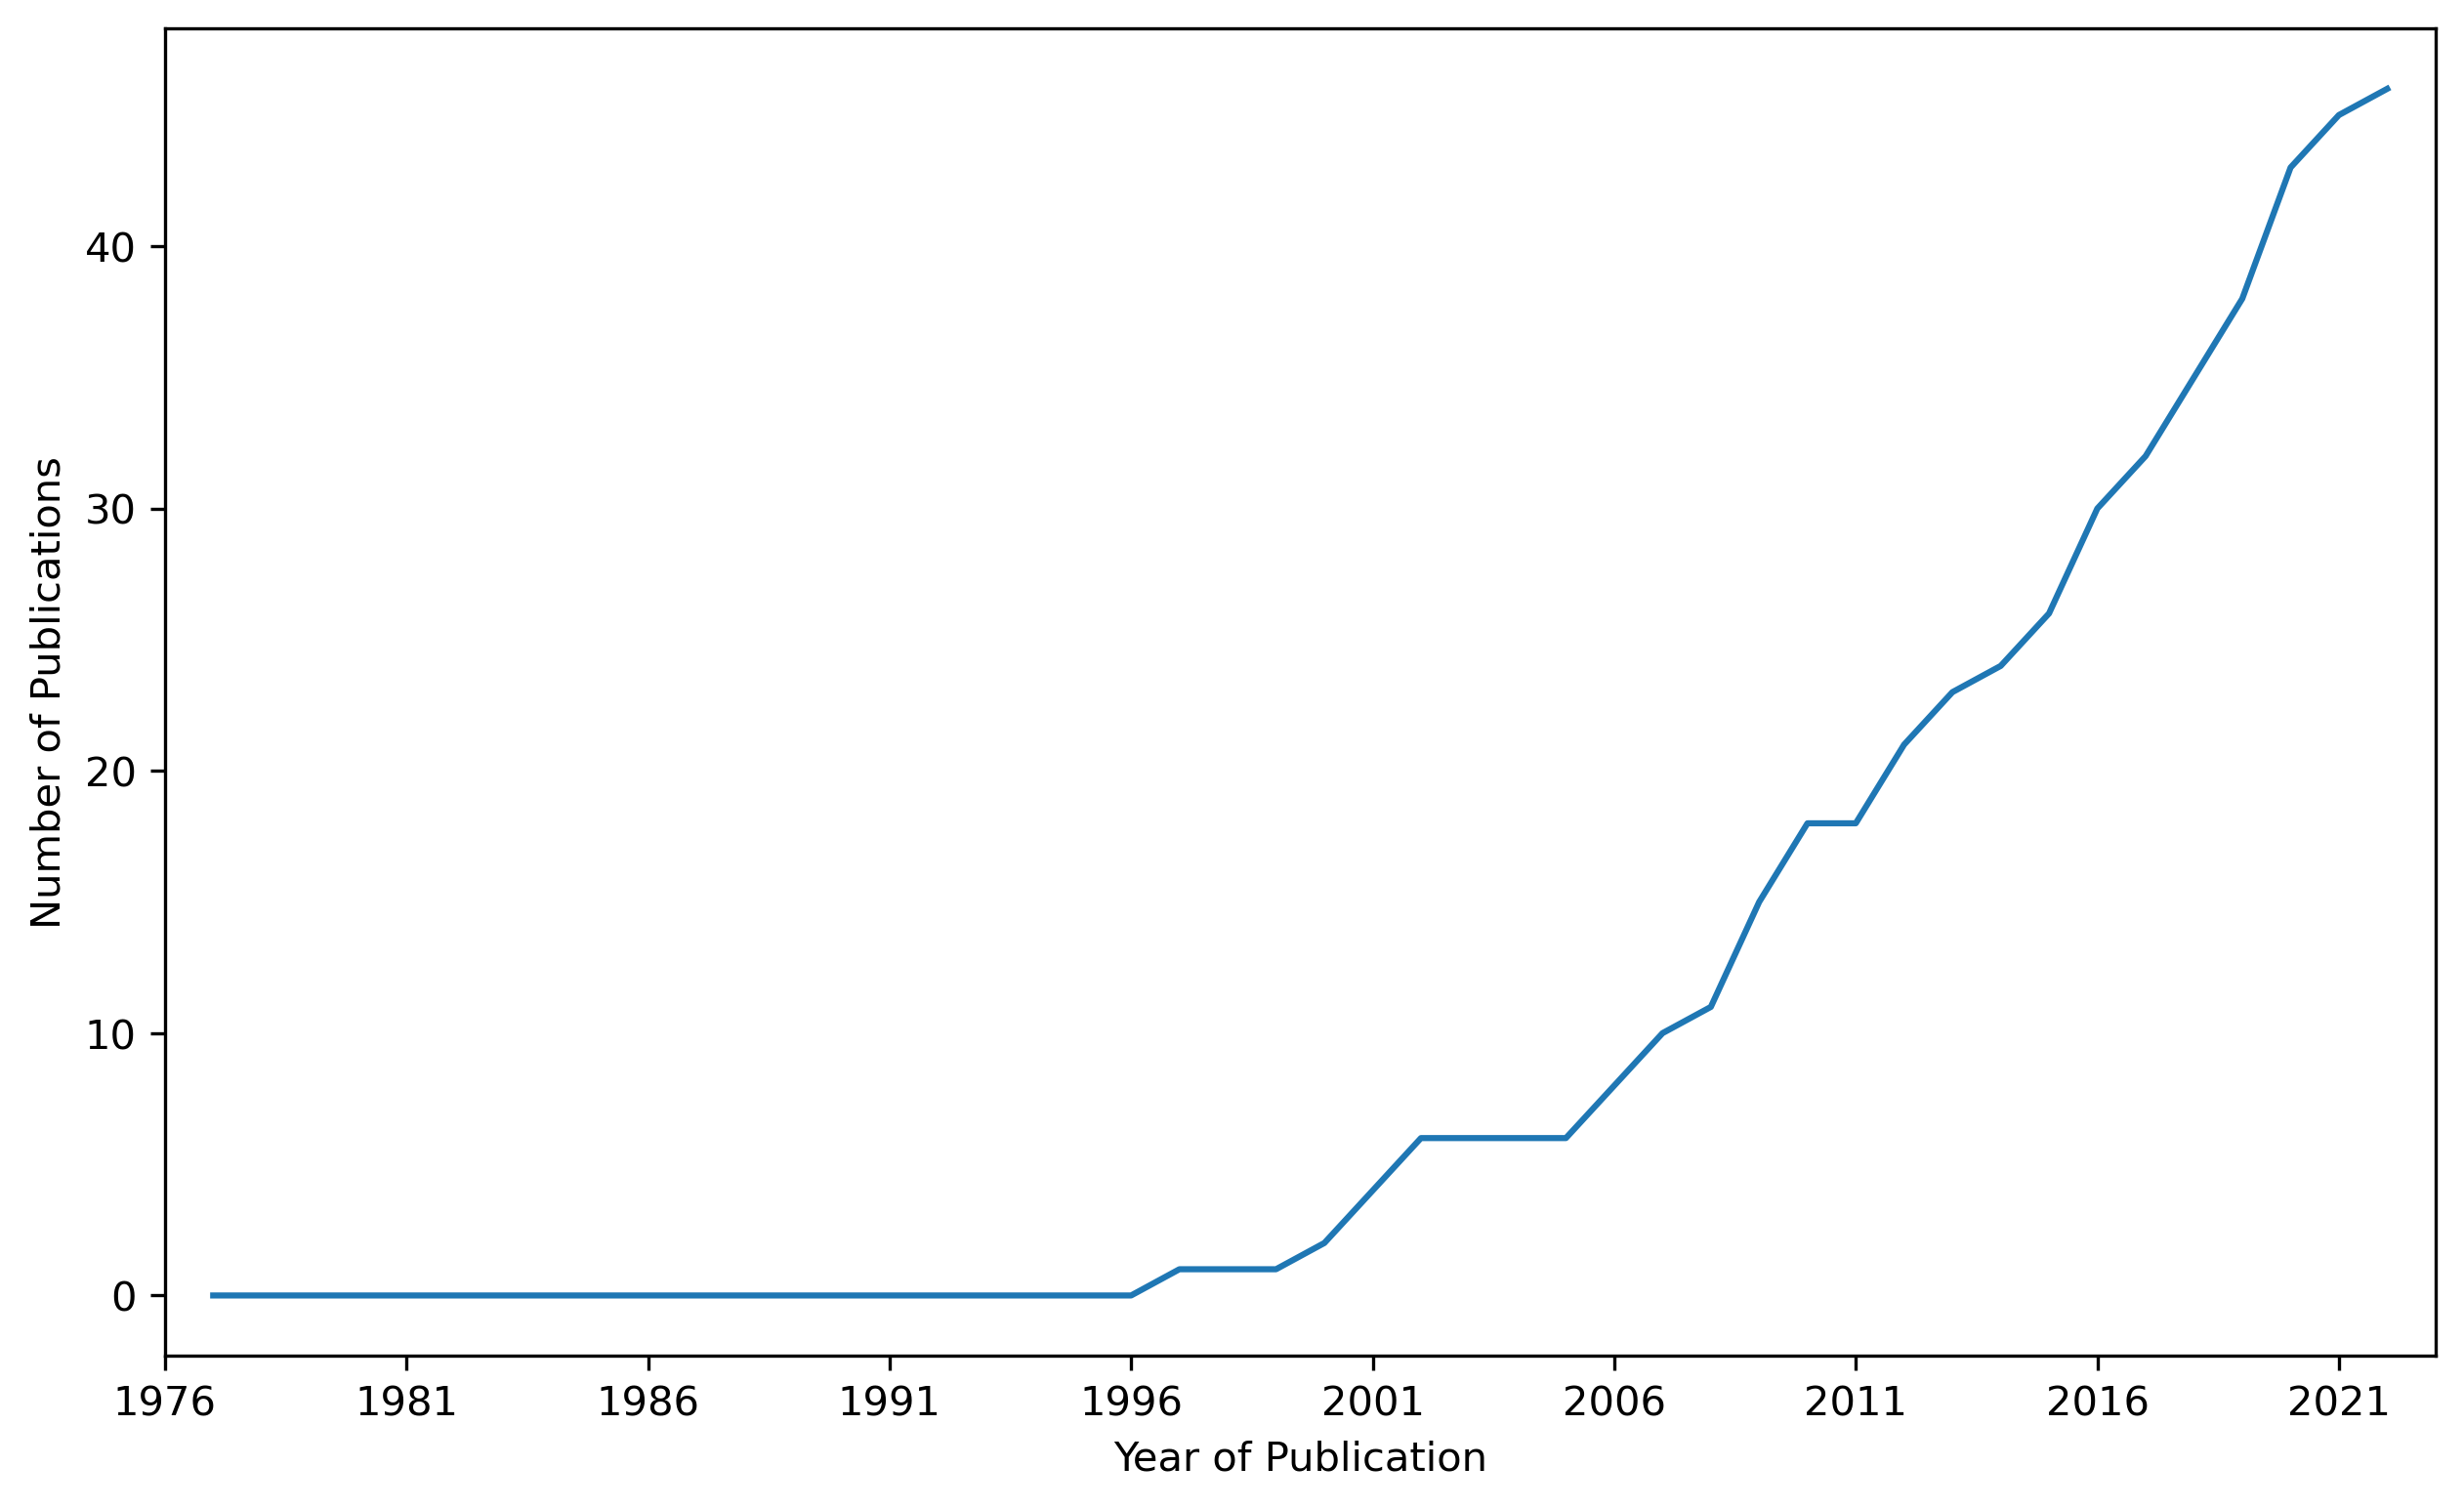

In [39]:
lookat = contain_values_M[(contain_values_M['Text'].str.contains(stemmer.stem("contract"))) | (contain_values_M['Text'].str.contains(stemmer.stem("warranty")))]

lookatgroup = lookat.groupby("Year")["Year"].count().to_dict()

for i in range(1977,2023):
    if i not in lookatgroup:
        lookatgroup[i] = 0
        
mykeys = list(lookatgroup.keys())
mykeys.sort()
sorted_lookatgroup = {i: lookatgroup[i] for i in mykeys}

yearsar = list(sorted_lookatgroup.keys())
valuesar = list(sorted_lookatgroup.values())

updateddf = pd.DataFrame(data = {"Year": yearsar, "Number of Publications": valuesar})
updateddf["Cumulative Number"] = updateddf["Number of Publications"].cumsum() 

plt.figure(figsize=(10, 6), dpi = 300)

sns.lineplot(x="Year",y="Cumulative Number",data= updateddf)

plt.xlabel("Year of Publication")
plt.ylabel("Number of Publications")
plt.xlim(1976,2023)
plt.xticks(range(1976,2023,5))
#plt.title("Cumulative Number of 'warranty', 'contract', or 'service' papers")

plt.savefig(".\Graphs\CumulWarrantyContract.jpg", format='jpeg', bbox_inches='tight')
plt.show()